In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from itertools import cycle, islice
from pivottablejs import pivot_ui
from Functions import *


# To delate warning messages

pd.options.mode.chained_assignment = None 

# Ligas para importar

In [2]:
Leagues = ['Premier League', 'Calcio', 'La Liga', 'Bundesliga', 'Francia']

def All_teams(League):

    dfs = []

    for i in League:
    
        df = get_data_for_league(i)
        dfs.append(df)
    
    return pd.concat(dfs)

df = All_teams(Leagues)


In [3]:
df

,Team,League,Year,Sec,Draw,Position,Points,B365_Draw
0,Aston Villa,Premier League,10,6,13,6,64,3.623421
1,Blackburn,Premier League,10,2,11,9,50,3.743158
2,Bolton,Premier League,10,4,9,14,39,3.802895
3,Chelsea,Premier League,10,15,5,1,86,5.049737
4,Everton,Premier League,10,6,13,8,61,3.683684
...,...,...,...,...,...,...,...,...
15,Monaco,Francia,19,1,12,17,36,3.673158
16,Rennes,Francia,19,2,13,10,52,3.520526
17,Nimes,Francia,19,4,8,9,53,3.703421
18,Strasbourg,Francia,19,1,16,11,49,3.686842


In [4]:
## Agrego una columna que muestre en que parte de la tabla finalizo el campeonato, donde 1 corresponde a los primeros 6

df['Table Sector'] = df['Position'].apply(lambda x: 1 if  7>x else ( 2 if  15 > x else 3 ))

## Cantidad de partidos seguidos sin empatar

In [36]:
## Hay 236 equipos que tuvieron 0 partidos seguidos sin empatar, es decir, empataron en la primer fecha

df['Sec'].value_counts()

0     236
1     185
2     148
3     114
4      76
5      55
6      47
7      33
8      18
9      16
12     12
10      9
11      9
14      5
13      4
18      3
19      3
26      1
15      1
16      1
17      1
20      1
24      1
28      1
Name: Sec, dtype: int64

## Total de empates por sector de la tabla

In [5]:
## Vemos que es muy dificil que los equipos de mitad de tabla para abajo empaten menos de 3 partidos por campeonato.

pd.crosstab(df['Table Sector'], df.Draw).transpose()

Table Sector,1,2,3
Draw,,,
2,3,1,0
3,7,1,1
4,23,6,7
5,10,12,5
6,31,17,19
7,49,30,35
8,34,42,38
9,54,62,38
10,32,55,28


## Secuencia de partidos sin empatar por sector

In [6]:
# Observamos que la mayor parte de equipos que empatan en la primer fecha son de mitad de tabla

pd.crosstab(df['Table Sector'], df.Sec).transpose()

Table Sector,1,2,3
Sec,,,
0,63,103,70
1,52,75,58
2,46,61,41
3,34,47,33
4,26,26,24
5,15,27,13
6,21,18,8
7,16,13,4
8,8,3,7


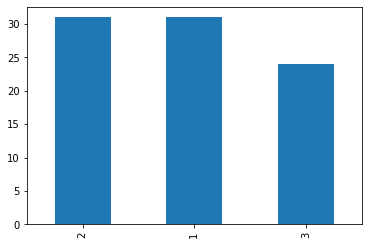

In [7]:
## No hay relacion en cuanto a los equipos que no empatan en mas de 7 fechas con su posicion en la tabla

df[df['Sec'] > 7]['Table Sector'].value_counts().plot.bar()

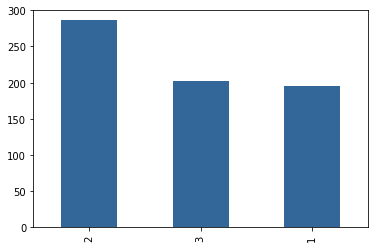

In [8]:
## Pero si vemos que levemente hay mas equipos de mitad de tabla que empatan antes del cuarto partido

df[df['Sec'] < 4]['Table Sector'].value_counts().plot.bar(color= (0.2,0.4,0.6))

# Agrego columnas con los flujos de cada semana

In [9]:
def Weeks(tabla, n):
    for i in range(tabla.shape[0]):
        if tabla.loc[i, 'Sec'] == n-1:
            tabla.loc[i, 'Week_'+str(n)] = tabla.loc[i, 'B365_Draw'] * ( 2 ** (n-1))
        elif tabla.loc[i, 'Sec'] < n-1:
            tabla.loc[i, 'Week_'+str(n)] = 0
        else:
            tabla.loc[i, 'Week_'+str(n)] = -(2 ** (n-1))

## Tomo los pagos y los retornos de cada semana

In [10]:
def Week_Paid(tabla):

    Paid = []

    for i in Week_list:
        paid = -(tabla[tabla[i] != 0][i].count() * (2 ** (int(i.split('_')[1])-1)))
        Paid.append(paid)
    return Paid

def Week_Return(tabla):

    Return = []

    for i in Week_list:
        retur = tabla[tabla[i] > 0][i].sum()
        Return.append(retur)
    return Return

## Creo una tabla con los resultados

In [69]:
def Create_Table(tabla, Start, Teams):

    df_2 = tabla.head(Teams)
    df_2 = df_2.reset_index(drop=True)

    list= range(1,11)
    for i in list:
        Weeks(df_2, i)

    Week = ['Week_1', 'Week_2','Week_3', 'Week_4','Week_5', 'Week_6','Week_7', 'Week_8','Week_9', 'Week_10']  
    Week_list = ['Week_1', 'Week_2','Week_3', 'Week_4','Week_5', 'Week_6','Week_7', 'Week_8','Week_9', 'Week_10']    
    Week = pd.DataFrame(Week)
            

    Se = Week_Paid(df_2)
    Week['Paid'] = Se


    re = Week_Return(df_2)
    Week['Return'] = re


    Week.columns = ['Week', 'Paid', 'Return']

    Week = Week[['Week', 'Paid','Return']]

    Week = Week.round(1)
    Week['Cash'] = 0
    Week['Insert'] = 0
    Week.loc[0, 'Cash'] = int(Start) + Week.loc[0, 'Return'] + Week.loc[0, 'Paid']

    for i in range(1, len(Week.Return)):
        if (Week.loc[i, 'Paid'] + Week.loc[i-1, 'Cash']) > 0:
            Week.loc[i, 'Cash'] = (Week.loc[i, 'Paid'] + Week.loc[i-1, 'Cash']) + Week.loc[i, 'Return']
        elif (Week.loc[i, 'Paid'] + Week.loc[i-1, 'Cash']) < 0:
            Week.loc[i, 'Cash'] = Week.loc[i,'Return']
            Week.loc[i, 'Insert'] = (Week.loc[i, 'Paid'] + Week.loc[i-1, 'Cash'])
    
        
    return Week

## Verifico la tabla

In [74]:
## Primero armo un df con los datos del inicio. 
## Puedo filtrar por alguna de los columnas, en este caso voy a tomar solo la Premier 

df_3 = df[(df.League == 'La Liga') & (df.Year == 19)]
df_3

,Team,League,Year,Sec,Draw,Position,Points,B365_Draw,Table Sector
0,Betis,La Liga,19,1,8,10,50,3.683158,2
1,Girona,La Liga,19,0,10,18,37,3.906579,3
2,Barcelona,La Liga,19,4,9,1,87,6.158158,1
3,Celta,La Liga,19,0,11,16,41,3.871842,3
4,Villarreal,La Liga,19,1,14,14,44,3.658684,2
5,Eibar,La Liga,19,3,14,12,47,3.745789,2
6,Real Madrid,La Liga,19,3,5,3,68,5.303158,1
7,Vallecano,La Liga,19,4,8,20,32,4.108684,3
8,Ath Bilbao,La Liga,19,1,14,7,53,3.542368,2
9,Valencia,La Liga,19,0,16,4,61,3.775000,1


In [76]:
## Create_Table tiene tres variables, la primera es la tabla de arriba,
## la segunda corresponde a con cuanto dinero quisiera arrancar
## y la tercera, cuantos equipos al azar quiero de la tabla filtrada

Week_list = ['Week_1', 'Week_2','Week_3', 'Week_4','Week_5', 'Week_6','Week_7', 'Week_8','Week_9', 'Week_10'] 
    
Week = Create_Table(df_3,40, 20)
Week

# Cash muestra el total que tiene la cuenta al finalizar la fecha. Recordar que hay que sumarle nuestra inversion inicial.

# En la primer semana pagamos 20 euros, 1 a cada equipo, y ganamos 18.8, mas los 10 iniciales, la cuenta termina en 8.8

# La columna Insert indica si necesitamos poner mas plata para alcanzar la apuesta de la semana.
# Es decir, en la segunda fecha, como debemos pagar 30 euros para apostar, y tenemos en la cuenta 8.8, debemos agregar 21

,Week,Paid,Return,Cash,Insert
0,Week_1,-20,23.0,43.0,0
1,Week_2,-28,60.3,75.3,0
2,Week_3,-24,29.8,81.1,0
3,Week_4,-32,72.4,121.5,0
4,Week_5,-32,164.3,253.8,0
5,Week_6,0,0.0,253.8,0
6,Week_7,0,0.0,253.8,0
7,Week_8,0,0.0,253.8,0
8,Week_9,0,0.0,253.8,0
9,Week_10,0,0.0,253.8,0


,Week,Paid,Return,Cash,Insert
0,Week_1,-20,21.2,21.2,0.0
1,Week_2,-30,47.7,47.7,-8.8
2,Week_3,-36,31.5,43.2,0.0
3,Week_4,-56,31.5,31.5,-12.8
4,Week_5,-96,65.7,65.7,-64.5
5,Week_6,-160,0.0,0.0,-94.3
6,Week_7,-320,249.1,249.1,-320.0
7,Week_8,-512,493.2,493.2,-262.9
8,Week_9,-768,0.0,0.0,-274.8
9,Week_10,-1536,2063.0,2063.0,-1536.0


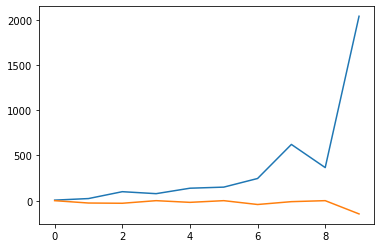

In [16]:
## Vemos el grafico

Week['Cash'].plot()
Week['Insert'].plot()

# Cantidad de equipos por liga con mas de 7 partidos sin el primer empate

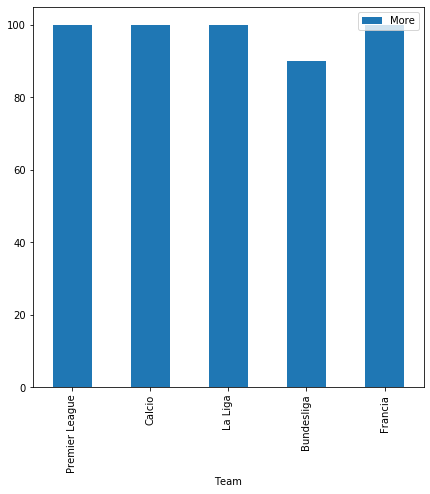

In [45]:
MoreThan7 = []

for i in Leagues:
    than = df[(df.League == i) & (df.Year < 15)]['Draw'].value_counts().sum()
    MoreThan7.append(than)
    
MoreThan7 = pd.DataFrame(MoreThan7)
MoreThan7['Team'] = Leagues
MoreThan7.columns = ['More', 'Team']
MoreThan7 = MoreThan7[['Team', 'More']]
MoreThan7 = MoreThan7.set_index('Team')
MoreThan7.plot.bar(figsize=(7,7))

In [82]:
df[(df['Position'] == 1) & (df['League'] == '') & (df.Year > 17)]['B365_Draw'].mean()

7.349736842105263

In [61]:
calcio = df[(df.League == 'Calcio') & (df.Year > 15) & (df.Sec > 6)]
calcio['Table Sector'].value_counts()

1    8
2    7
3    3
Name: Table Sector, dtype: int64

In [51]:
LaLiga18 =Importar_Liga_Año('La Liga', 2018)
LaLiga18[(LaLiga18.HomeTeam == 'Alaves') | (LaLiga18.AwayTeam == 'Alaves') ]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,18/08/2017,Leganes,Alaves,1,0,H,1,0,H,16,...,1.46,18,-0.50,2.07,2.03,1.90,1.86,1.98,3.35,4.63
12,26/08/2017,Alaves,Barcelona,0,2,A,0,0,D,11,...,2.38,14,1.50,2.05,2.00,1.92,1.89,10.13,5.83,1.33
26,10/09/2017,Celta,Alaves,1,0,H,1,0,H,20,...,1.81,14,-0.75,1.99,1.95,1.95,1.92,1.68,3.91,5.87
35,17/09/2017,Alaves,Villarreal,0,3,A,0,1,A,16,...,1.59,15,0.25,1.87,1.84,2.06,2.03,3.12,3.28,2.53
43,20/09/2017,La Coruna,Alaves,1,0,H,1,0,H,15,...,1.67,14,-0.50,1.92,1.89,2.03,2.00,1.75,3.89,5.20
50,23/09/2017,Alaves,Real Madrid,1,2,A,1,2,A,8,...,3.20,18,2.00,2.20,2.13,1.80,1.75,18.70,8.50,1.18
63,30/09/2017,Levante,Alaves,0,2,A,0,1,A,13,...,1.69,15,-0.75,2.20,2.12,1.81,1.76,1.89,3.48,4.89
71,14/10/2017,Alaves,Sociedad,0,2,A,0,0,D,8,...,1.95,17,0.25,2.08,2.02,1.91,1.85,NaN,NaN,NaN
81,21/10/2017,Betis,Alaves,2,0,H,1,0,H,12,...,1.98,20,-1.00,2.06,2.01,1.89,1.85,1.62,4.10,6.32
90,28/10/2017,Alaves,Valencia,1,2,A,0,1,A,16,...,1.97,19,0.75,2.13,2.07,1.85,1.81,5.43,4.15,1.68


In [53]:
df.to_csv("C:\\Users\\juano\\Desktop\\Leagues.csv")